# Exercise 6

The number of busy lines in a trunk group (Erlang system) is
given by a truncated Poisson distribution
P(i) = c ·
Ai
i!
, i = 0, . . . m
Generate values from this distribution by applying the
Metropolis-Hastings algorithm, verify with a χ
2
-test. You can
use the parameter values from exercise 4

In [2]:
from scipy.special import factorial
import numpy as np
from scipy.stats import chi2
from scipy.stats import chisquare
from scipy.stats import poisson
import plotly.graph_objects as go


In [3]:
m = 10 #number of servers
s = 8 #mean service time
lam = 1#arrival_intensity
N =100000 #10*10000
A = lam*s


In [4]:
#1The number of busy lines in a trunk group (Erlang system) is
#given by a truncated Poisson distribution

#unnormalized probability mass function
g = lambda x : A**x / factorial(x)


def metropolis_hastings(g,N,m, burn_in = int(N)):
    #X and Y are random integers from 0 to m
    U = np.random.uniform(0,1,N + burn_in)
    X = np.zeros(N + burn_in,dtype = int)
    X[0] = 3
    #prob_of_sampling = np.minimum(g(X)/g(Y),np.ones(N))
    #sample X with probability prob_of_sampling
    for i in range(1,N+burn_in):
        x = X[i-1]
        y = np.random.randint(0,m+1)
        
        if U[i] <= min(g(y) / g(x),1) :
            X[i] = y
        else:
            X[i] = x
            
    # X = np.where(U<prob_of_sampling,X,Y)
    X = X[burn_in:]
    return X

def truncated_poisson_samples(lam, low, high, size=1, numvars = 1):
    samples = []
    while len(samples) < size:
        x = np.random.poisson(lam, numvars)
        if low <= x <= high:
            samples.append(x)
    return np.array(samples)

X_est = metropolis_hastings(g,N,m)
#X_est is the number of busy lines in a trunk group
#create histogram and plot i
hist_estimate,_ = np.histogram(X_est, bins = np.arange(m+2))

#sample from the truncated poisson distribution
X_expected = truncated_poisson_samples(A, 0, m, N)
hist_expected,_ = np.histogram(X_expected, bins = np.arange(m+2))

#Do a Plotly histogram of the estimated values and the expected values in the same plot
fig = go.Figure()
fig.add_trace(go.Bar(x = list(range(m+1)), y = hist_estimate, name = 'Estimated'))
fig.add_trace(go.Bar(x = list(range(m+1)), y = hist_expected, name = 'Expected'))
fig.update_layout(title = 'Estimated and Expected values of the number of busy lines in a trunk group',
                  xaxis_title = 'Number of busy lines',
                  yaxis_title = 'Count')
fig.show()

T, p_value = chisquare(hist_estimate/N, hist_expected/N)
print('Chi-square test statistic:', T)
print('P-value:', p_value)

Chi-square test statistic: 0.0002496774797004261
P-value: 1.0


### 2
For two different call types the joint number of occupied lines
is given by ... 
You can use A1, A2 = 4 and m = 10

#### a)
Use Metropolis-Hastings, directly to generate variates from
this distribution.

In [5]:
A1 = 4
A2 = 4

def g_joint(A1,A2):
    return lambda x,y : A1**x / factorial(x) * A2**(y) / factorial(y)

def joint_truncated_poisson_samples(A1, A2, low, high, size=1):
    samples = []
    while len(samples) < size:
        x = np.random.poisson(A1)
        y = np.random.poisson(A2)
        if low <= x + y <= high:
            samples.append((x,y))
    return np.array(samples)

In [95]:
def y_sampling():
    y1 = np.random.randint(0,m+1)
    y2 = np.random.randint(0,m+1-y1)
    #create y as (y1,y2) or (y2,y1) with equal probability
    return (y1,y2) if np.random.uniform(0,1) < 0.5 else (y2,y1)
    

def metropolis_hastings_joint(g_joint,N,m, burn_in = 2*int(N), y_sampling_func = y_sampling):
    #X and Y are random integers from 0 to m
    U = np.random.uniform(0,1,N + burn_in)
    X = np.zeros((N + burn_in,2),dtype = float)
    X[0] = (1.0,1.0)
    #prob_of_sampling = np.minimum(g(X)/g(Y),np.ones(N))
    #sample X with probability prob_of_sampling
    for i in range(1,N+burn_in):
        x = X[i-1]
        y = y_sampling_func()
        if U[i] <= min(g_joint(y[0],y[1]) / g_joint(x[0],x[1]),1) :
            X[i] = y
        else:
            X[i] = x
    # X = np.where(U<prob_of_sampling,X,Y)
    X = X[burn_in:]
    return X

In [7]:
X_est_joint = metropolis_hastings_joint(g_joint(A1,A2),N,m)
X_true_joint = joint_truncated_poisson_samples(A1,A2,0,m,N)

#joint histogram estimate
hist_joint_estimate,_,_ = np.histogram2d(X_est_joint[:,0],X_est_joint[:,1], bins = [np.arange(m+2),np.arange(m+2)])
#joint histogram true
hist_joint_true,_,_ = np.histogram2d(X_true_joint[:,0],X_true_joint[:,1], bins = [np.arange(m+2),np.arange(m+2)])
#plot the joint estimated joint histogram
fig = go.Figure(data = [go.Heatmap(z = hist_joint_estimate)])
fig.update_layout(title = 'Estimated joint histogram of the number of busy lines in a trunk group',
                  xaxis_title = 'Number of busy lines in trunk 1',
                  yaxis_title = 'Number of busy lines in trunk 2')
fig.show()
#plot the joint true joint histogram
fig = go.Figure(data = [go.Heatmap(z = hist_joint_true)])
fig.update_layout(title = 'True joint histogram of the number of busy lines in a trunk group',
                  xaxis_title = 'Number of busy lines in trunk 1',
                  yaxis_title = 'Number of busy lines in trunk 2')
fig.show()

In [8]:
#calculate the test statistic for all histograms > 0
T, p_value = chisquare(hist_joint_estimate.flatten()[hist_joint_estimate.flatten() > 0]/N, hist_joint_true.flatten()[hist_joint_estimate.flatten() > 0]/N)
print('Chi-square test statistic:', T)
print('P-value:', p_value)

Chi-square test statistic: 0.029065875247617362
P-value: 1.0


### c
Use Gibbs sampling to sample from the distribution. This is
(also) coordinate-wise but here we use the exact conditional
distributions. You will need to find the conditional
distributions analytically

In [9]:
# TODO

### 3
 We consider a Bayesian statistical problem. The observations
are Xi ∼ N(Θ, Ψ), where the prior distribution of the pair
(Ξ, Γ) = (log (Θ), log (Ψ)) is standard normal with correlation
ρ. The posterior distribution of (Θ, Ψ) is given by...
which can be derived using a standard change of variable
technique. The task of this exercise is now to sample from the
posterior distribution of (Θ, Ψ) using Markov Chain Monte
Carlo.

#### a)
 Generate a pair (θ, ψ) from the prior distribution, i.e. the
distribution for the pair (Θ, Ψ), by first generating a sample
(ξ, γ) of (Ξ, Γ).


In [55]:
#xi and gamma of (Ξ, Γ) = (log (Θ), log (Ψ)) 
#joint density of Theta and Psi is normal with correlation rho = 0.5
rho = 0.5

#sample from the joint density
θ, ψ =np.exp(np.random.multivariate_normal([0,0],[[1,rho],[rho,1]]))
print('θ:',θ)
print('ψ:',ψ)

θ: 1.6705343248151687
ψ: 2.1448233856116428


#### b)
 Generate Xi = 1, . . . , n with the values of (θ, ψ) you
obtained in item 3a. Use n = 10

In [122]:
n = 200
#generate n samples from the univariate distribution N(θ,ψ)
np.random.seed(100)
X = np.random.normal(θ,ψ,n)
#The log-likelihood of the data X given the parameters θ and ψ is. Each X follows Normal(θ,ψ)
likelihood = lambda X,θ,ψ : np.exp(-n/2*np.log(2*np.pi) - n*np.log(ψ) - 1/(2*ψ+ 1e-16)*np.sum((X-θ)**2))
#  The joint density f(x, y) of (Θ, Ψ) is
prior = lambda  x,y : 1/(2*np.pi*x*y*np.sqrt(1-rho**2))*np.exp(-1/(2*(1-rho**2))*(np.log(x)**2 - 2*rho*np.log(x)*np.log(y) + np.log(y)**2))

#y is sampled from a folded normal distribution
y_sampling_bays = lambda : np.abs(np.random.normal(0,1,2))

posterior = lambda X : lambda θ,ψ : likelihood(X,θ,ψ)*prior(θ,ψ)
posterior(X)(θ,ψ)

1.6413372886269911e-245

θ: 1.6705343248151687
ψ: 2.1448233856116428


[]

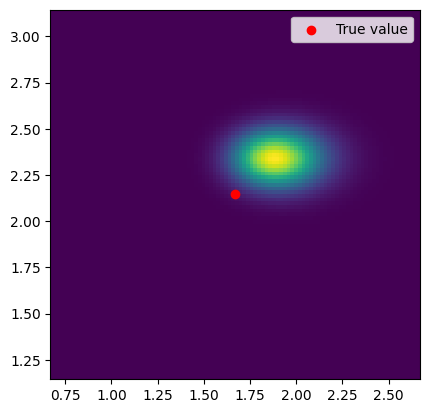

In [123]:
#joint histogram of posterior(X)
from matplotlib import pyplot as plt
hist_size = 100
print('θ:',θ)
print('ψ:',ψ)
#create a linspace centered around the true value of θ and ψ
thetas = np.linspace(θ-1,θ+1,hist_size)
psis = np.linspace(ψ-1,ψ+1,hist_size)
hist_posterior = np.zeros((hist_size,hist_size))
for i,theta in enumerate(thetas):
    for j,psi in enumerate(psis):
        hist_posterior[i,j] = posterior(X)(theta,psi)
plt.imshow(hist_posterior, extent = [thetas[0],thetas[-1],psis[0],psis[-1]])
#scatter of the theta and psi values used to generate the data X
plt.scatter(θ,ψ,c = 'r', label = 'True value')
plt.legend()
plt.plot()

In [110]:
X_est_joint = metropolis_hastings_joint(posterior(X),N,m, y_sampling_func= y_sampling_bays)

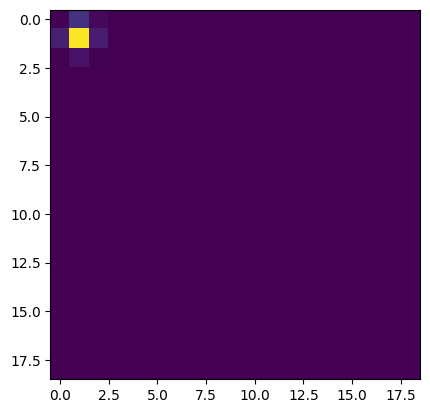

In [116]:
#joint histogram estimate
hist_joint_estimate,_,_ = np.histogram2d(X_est_joint[:,0],X_est_joint[:,1], bins = [np.arange(m+2),np.arange(m+2)])

In [117]:
?np.histogram2d

Signature:       np.histogram2d(x, y, bins=10, range=None, density=None, weights=None)
Call signature:  np.histogram2d(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function histogram2d at 0x0000027FFF546AC0>
File:            c:\users\mgaj\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\numpy\lib\twodim_base.py
Docstring:      
Compute the bi-dimensional histogram of two data samples.

Parameters
----------
x : array_like, shape (N,)
    An array containing the x coordinates of the points to be
    histogrammed.
y : array_like, shape (N,)
    An array containing the y coordinates of the points to be
    histogrammed.
bins : int or array_like or [int, int] or [array, array], optional
    The bin specification:

      * If int, the number of bins for the two dimensions (nx=ny=bins).
      * If array_like, the bin edges for the two dimensions
        (x_edges=y_edges=bins).
      * I